<a href="https://colab.research.google.com/github/FGR02/tps/blob/main/Trabajo_Pr%C3%A1ctico_MN_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
from numba import jit

# **1. Eliminación Gaussiana sin pivoteo.**

In [ ]:
def solve_sin_pivoteo(A, b):
  n = A.shape[0]
  if(n != A.shape[1]): # verificamos que la matriz sea cuadrada
    return -1
  if(A[0][0] == 0 and A[1][1] != 0): # si A11 = 0 y A21 != 0 no hay solución única
    return -1
  x = np.reshape(np.zeros(n), (n, 1))
  #b = np.reshape(b, (-1, 1))

  # Para triangular A hay que, en cada paso i, restarle a todas las filas a partir de i (de j=i+1 a n)
  # un múltiplo adecuado de la fila i a la fila j. También le aplicamos las mismas operaciones a b.
  for i in range(n):
    for j in range(i+1, n):
      multiplier = A[j][i] / A[i][i]
      A[j] = A[j] - (multiplier * A[i])
      b[j] = b[j] - (multiplier * b[i])
  # una vez triangulada la matriz, resolvemos el sistema de 'atrás hacia adelante'
  for i in range(n - 1, -1, -1):
    k = b[i]
    for j in range(i + 1, n):
      k = k - (x[j] * A[i][j])
    x[i] = k / A[i][i]
  return x


In [ ]:
A = np.array([[1, 1, 1], [3, 4, 7], [1, 9, 5]])
b = np.array([3, 4, 5]).reshape(-1,1)

print(A[0:3, 0], "\n")

x = solve_sin_pivoteo(A, b)
print("A:", "\n", A, "\n")
print("b:", "\n", b, "\n")
print("x", "\n", x, "\n")
print("Ax:", "\n", A@x, "\n")
print(np.allclose(A@x, b))



[1 3 1] 

A: 
 [[  1   1   1]
 [  0   1   4]
 [  0   0 -28]] 

b: 
 [[ 3]
 [-5]
 [42]] 

x 
 [[ 3.5]
 [ 1. ]
 [-1.5]] 

Ax: 
 [[ 3.]
 [-5.]
 [42.]] 

True


# **2. Eliminación Gaussiana con pivoteo.**

In [176]:
@jit
def columnIsAllZeroes(A, i):
    for j in range(len(A)):
        if (A[j][i] != 0):
            return False
    return True
@jit
def ParcialPivotLine(A, b, i):
    biggestModuleNumber = abs(A[i][i])
    indexOfBiggestModule = i
    for j in range(i+1, len(A)):
        if (abs(A[j][i]) > biggestModuleNumber):
            biggestModuleNumber = abs(A[j][i])
            indexOfBiggestModule = j
    for j in range(i, len(A)):
        A[i][j] = A[i][j]-A[indexOfBiggestModule][j]
    b[i] = b[i]-b[j]

@jit
def solve_con_pivoteo(A, b, ξ):
    for i in range(len(A)-1):
        if (A[i][i] == 0):
            if columnIsAllZeroes(A, i):
                raise Exception(
                    "Hay 0 o infinitas soluciones para el sistema lineal")
            else:
                ParcialPivotLine(A, b, i)
        for j in range(i+1, len(A)):
            if abs(A[i][i]) < ξ:
                print(
                    "posible error numerico al dividir por:", A[i][i], "ya que es un numero debajo de la tolerancia de:", ξ)
            multiplier = A[j][i] / A[i][i]
            if(multiplier!= 0):
              for k in range(i, len(A)):
                  A[j][k] = A[j][k] - multiplier*A[i][k]
              b[j] = b[j]-multiplier*b[i]
    res = np.zeros(len(A))
    for i in range(len(A)-1, -1, -1):
        solvedSum = 0
        for j in range(i, len(A)):
            solvedSum += A[i][j] * res[j]
        res[i] = (b[i] - solvedSum) / A[i][i]
        if abs(A[i][i]) < ξ:
            print(
                "posible error numerico al dividir por:", A[i][i], "ya que es un numero debajo de la tolerancia de:", ξ)
    return res

In [52]:
A = np.array([[1, 1, 1, 5], [0, 4, 7, 7], [1, 9, 0, 1], [2, 0, 3, 20]], dtype = float)
#A = np.array([[1, 0, 0, 0], [0, 2, 0, 0], [0, 0, 3, 6], [0, 0, 0, 7]])
b = np.array([1, 1, 1, 2])


x = solve_con_pivoteo(A, b, 0.001)
print("A:", "\n", A, "\n")
print("b:", "\n", b, "\n")
print("x", "\n", x, "\n")
print("Ax:", "\n", A@x, "\n")
print(np.allclose(A@x, b))

A: 
 [[  1.    1.    1.    5. ]
 [  0.    4.    7.    7. ]
 [  0.    0.  -15.  -18. ]
 [  0.    0.    0.    8.1]] 

b: 
 [ 1  1 -2  0] 

x 
 [0.85       0.01666667 0.13333333 0.        ] 

Ax: 
 [ 1.  1. -2.  0.] 

True


# **3. Eliminación Gaussina para una matriz tridiagonal.**

In [169]:
"""
Es posible realizar eliminación gaussiana para una matriz tridiagonal de nxn con n pasos:
  1. F2 - F1
  2. F3 - F2
  ...
  n. Fn - Fn-1
Y aprovechando que la matriz está dada por a, b y c (y d) y el resto son valores nulos, se pueden realizar operaciones únicamente entre estos vectores.
"""
def solve_tri(a , b, c, d):
    if not (len(a) == len(b) and len(b) == len(c) and len(c) == len(d)):
        raise Exception(
            "Los vectores son de diferente largo, no se puede aplicar el algoritmo")
    else:
        n = len(a)
        for i in range(n-1):
            multiplier = a[i+1]/b[i]
            b[i+1] -= multiplier*c[i]
            d[i+1] -= multiplier*d[i]
        x = np.zeros(n+1)
        x[-1] = d[-1] / b[-1]
        for i in range(n-2, -1, -1):
            solvedSum = d[i]-c[i]*x[i+1]
            x[i] = solvedSum/b[i]
        return x
@jit
def precomputoTridiagonal(a, b, c):
    if not (len(a) == len(b) and len(b) == len(c)):
        raise Exception(
            "Los vectores son de diferente largo, no se puede aplicar el algoritmo")
    else:
        n = len(a)
        for i in range(n-1):
            multiplier = a[i+1]/b[i]
            a[i] = multiplier
            b[i+1] = b[i+1] - multiplier*c[i]
@jit
def calcularPostComputoSolucionSistemaTridiagonal(a, b, c, d):
    n = len(a)
    for i in range(n-1):
        multiplier = a[i]
        d[i+1] = d[i+1] - multiplier * d[i]
    res = np.zeros(n)
    res[-1] = d[-1] / b[-1]
    for i in range(n-2, -1, -1):
        solvedSum = d[i]-c[i]*res[i+1]
        res[i] = solvedSum/b[i]
    return res


In [ ]:
b = np.array([1, 2, 2, 2, 5, 2], dtype = float) # diagonal principal
c = np.array([8, 1, 1, 1, 1], dtype = float)  # diagonal superior
a = np.array([1, 1, 1, 1, 3], dtype = float)  # diagonal inferior
d = np.array([1, 6, 8, 9, 11, 3], dtype = float)

A = np.diag(b) + np.diag(a, k=-1) + np.diag(c, k=1)

print(A, "\n")
x_np = np.linalg.solve(A, d)
print("Numpy x:", "\n", np.linalg.solve(A, d), "\n")
b = np.array([1, 2, 2, 2, 5, 2], dtype = float) # diagonal principal
c = np.array([8, 1, 1, 1, 1, 0], dtype = float)  # diagonal superior
a = np.array([0, 1, 1, 1, 1, 3], dtype = float)  # diagonal inferior
d = np.array([1, 6, 8, 9, 11, 3], dtype = float)
x = solve_tri(a,b,c,d)
print("x propio:", "\n", x, "\n")
print(np.allclose(x, x_np))


[[1. 8. 0. 0. 0. 0.]
 [1. 2. 1. 0. 0. 0.]
 [0. 1. 2. 1. 0. 0.]
 [0. 0. 1. 2. 1. 0.]
 [0. 0. 0. 1. 5. 1.]
 [0. 0. 0. 0. 3. 2.]] 

Numpy x: 
 [ 3.31578947 -0.28947368  3.26315789  1.76315789  2.21052632 -1.81578947] 

x propio: 
 [3.3157894736842093, -0.28947368421052616, 3.263157894736843, 1.7631578947368418, 2.210526315789474, -1.8157894736842113] 

True


# **4 Verificación de la implementación.**

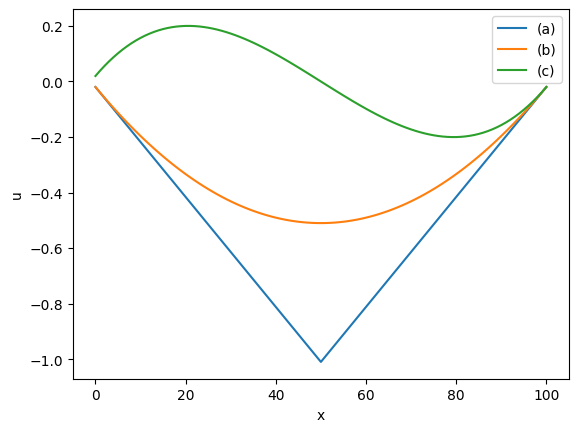

In [ ]:
n = 101
a = np.full(n, 1, dtype=np.float64)
a[0] = 0
b = np.full(n, -2, dtype=np.float64)
c = np.full(n, 1, dtype=np.float64)
c[n-1] = 0
precomputoTridiagonal(a, b, c)
d1 = np.zeros(n)
d1[n//2] = 4/n
d2 = np.full(n, 4/(n**2))
d3 = [0] * n
for i in range(n):
    d3[i] = (-1+2*i/(n-1)) * 12/n**2
res = calcularPostComputoSolucionSistemaTridiagonal(a, b, c, d1)
res2 = calcularPostComputoSolucionSistemaTridiagonal(a, b, c, d2)
res3 = calcularPostComputoSolucionSistemaTridiagonal(a, b, c, d3)

x = np.arange(0,n)
plt.plot(x, res,label='(a)')
plt.plot(x, res2,label='(b)')
plt.plot(x, res3,label='(c)')
plt.ylabel('u')
plt.xlabel('x')
plt.legend()
plt.show()


# **5.1 Verificación de la implementación de sistemas tridiagonales.**

10
20
50
100
10
20


<ipython-input-7-c1a186792daa>:16: RuntimeWarning: divide by zero encountered in scalar divide
  multiplier = a[i+1]/b[i]
<ipython-input-7-c1a186792daa>:18: RuntimeWarning: invalid value encountered in scalar multiply
  d[i+1] -= multiplier*d[i]


50
100


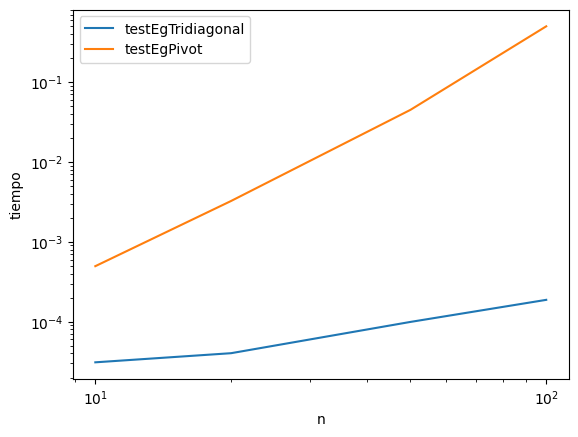

In [ ]:
def setup_for_test(n):
    a = np.full(n, 1, dtype=float)
    a[0] = 0
    b = np.full(n, -2, dtype=float)
    c = np.full(n, 1, dtype=float)
    c[n-1] = 0
    d = np.full(n, 4/(n**2), dtype=float)
    return a, b, c, d


repetitions = 100

def testEgPivot(n):
    a = np.diag(np.ones(n-1, dtype=float), -1)
    b = np.diag((-2)*np.ones(n, dtype=float))
    c = np.diag(np.ones(n-1, dtype=float), 1)
    AA = a+b+c
    dd = np.full(n, 4/(n**2), dtype=float)
    print(n)
    return timeit.timeit(stmt= 'A,d=AA,dd;solve_con_pivoteo(A,d,1)',
    setup= 'from __main__ import solve_con_pivoteo; AA, dd',
    globals=locals(),
    number=repetitions)/repetitions


def testEgTridiagonal(n):
    aa, bb, cc, dd = setup_for_test(n)
    print(n)
    return timeit.timeit(stmt= 'a,b,c,d = aa,bb,cc,dd;solve_tri(a,b,c,d)',
    setup= 'from __main__ import solve_tri; aa, bb, cc, dd',
    globals=locals(),
    number=repetitions)/repetitions

x = [10,20,50,100]
yForEgTridiagonal = np.array([testEgTridiagonal(xi) for xi in x])
yForEgPivot = np.array([testEgPivot(xi) for xi in x])
plt.plot(x, yForEgTridiagonal,
         label='testEgTridiagonal')
plt.plot(x, yForEgPivot,
         label='testEgPivot')
plt.ylabel('tiempo')
plt.xlabel('n')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


# **5.2 Tridiagonal sin pre cómputo vs tridiagonal con pre cómputo**

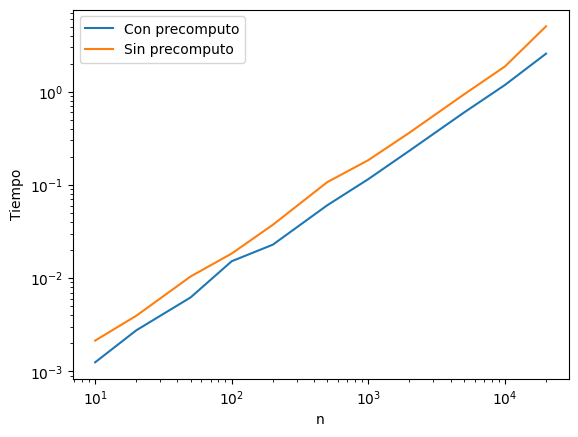

In [ ]:

def testEgTridiagonal(n):
  return timeit.timeit(
    stmt='a, b, c, d = setup_for_test(101);solve_tri(a, b, c, d)',
    setup='solve_tri,setup_for_test',
    globals=globals(),
    number=n
  )


def testEgTridiagonalPrecomputo(n):
  a, b, c, d = setup_for_test(101)
  precomputoTridiagonal(a, b, c)
  return timeit.timeit(
    stmt='calcularPostComputoSolucionSistemaTridiagonal(a, b, c, d)',
    setup='testEgTridiagonalPrecomputo, a, b, c, d',
    globals=globals(),
    number=n
  )




a, b, c, d = setup_for_test(101)
x = [10, 20, 50, 100, 200,500,1000,2000,5000,10000,20000]
yForEgTridiagonalConPrecomputo = np.array([testEgTridiagonalPrecomputo(xi) for xi in x])
yForEgTridiagonalSinPrecomputo = np.array([testEgTridiagonal(xi) for xi in x])
plt.plot(x, yForEgTridiagonalConPrecomputo,
         label='Con precomputo')
plt.plot(x, yForEgTridiagonalSinPrecomputo,
         label='Sin precomputo')
plt.ylabel('Tiempo')
plt.xlabel('n')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


# **6. Simulación de difusión**

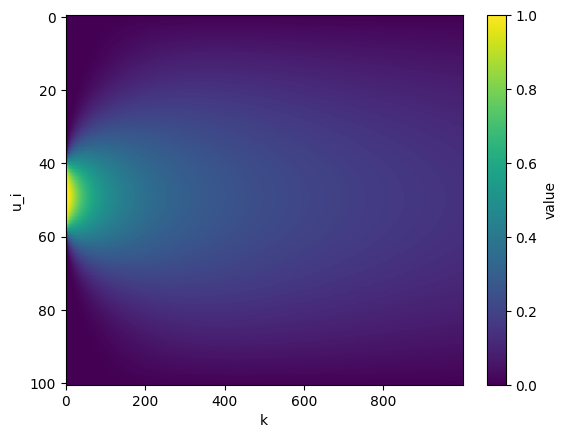

In [171]:
@jit
def setup_for_diffusion(n,α):
    a = np.full(n, -α, dtype=float)
    a[0] = 0
    b = np.full(n, 1+α*2, dtype=float)
    c = np.full(n, -α, dtype=float)
    c[n-1] = 0
    return a, b, c
@jit
def simulateDifusion(m,u,α):
  a,b,c = setup_for_diffusion(len(u),α)
  precomputoTridiagonal(a, b, c)
  for i in range(m):
    u = calcularPostComputoSolucionSistemaTridiagonal(a,b,c,u)
  return u

@jit
def testDiffussion(m,n,α):
  u = np.zeros(n)
  middle = n//2
  u[middle-r:middle+r-1] = 1
  return simulateDifusion(m,u,α)

def transform_arrays(arrays):
    # Use zip to transpose the arrays
    return [list(col) for col in zip(*arrays)]

n = 101
r = 10
α = 1
m = 1000
x = np.arange(0,m)
yForTestingDiffussion = np.array([testDiffussion(xi,n,α) for xi in x])
transformedY = transform_arrays(yForTestingDiffussion)
plt.ylabel('u_i')
plt.xlabel('k')
plt.imshow(transformedY,cmap='viridis',aspect='auto')
plt.colorbar(label='value')

# Example usage:
arrays = [
    [1, 2, 3],
    [4, 5, 6],
    [7, 8, 9]
]

# **7. Simulación de difusión de calor en 2d**

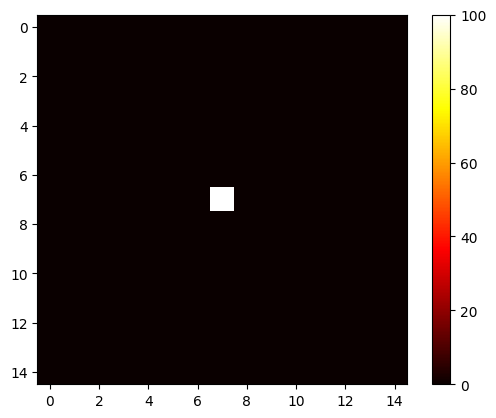

In [177]:
@jit
def setup_for_2d_diffusion(n,α):
    N = n * n  # Total number of grid points
    L = np.zeros((N, N), dtype=float)
    u = np.zeros(N,dtype=float)
    u[N//2] = 100
    for i in range(N):
        L[i, i] = 1+α*4

        # Si tiene vecino atras conecta
        if i % n != 0:
            L[i, i-1] = -α

        # Si tiene vecino adelante conecta
        if (i+1) % n != 0:
            L[i, i+1] = -α

        # Paso la primera fila por ende tiene vecino arriba (arriba siendo n posiciones arriba)
        if i >= n:
            L[i, i-n] = -α

        # No esta en la ultima fila, por ende conecto con vecino abajoabajo siendo n posiciones abajo)
        if i < N - n:
            L[i, i+n] = -α
    return L,u
@jit
def simulate2DDifusion(t,n,α):
  AA,u = setup_for_2d_diffusion(n,α)
  N = n*n
  for i in range(t):
    A = AA.copy()
    u = solve_con_pivoteo(A,u,0)
    u[N//2] = 100
  return u

n = 15
α=0.1
t=0
u = simulate2DDifusion(t,n,α)
plt.imshow(u.reshape(n,n),cmap='hot')
plt.colorbar()



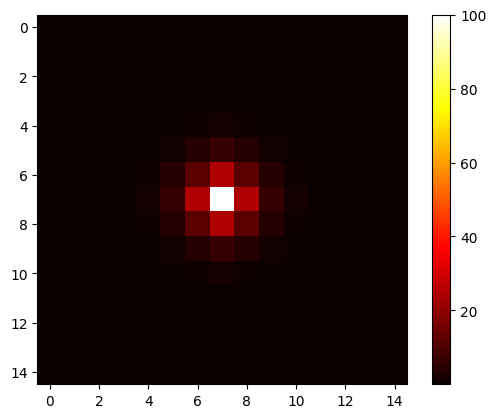

In [178]:
t=10
u = simulate2DDifusion(t,n,α)
plt.imshow(u.reshape(n,n),cmap='hot')
plt.colorbar()


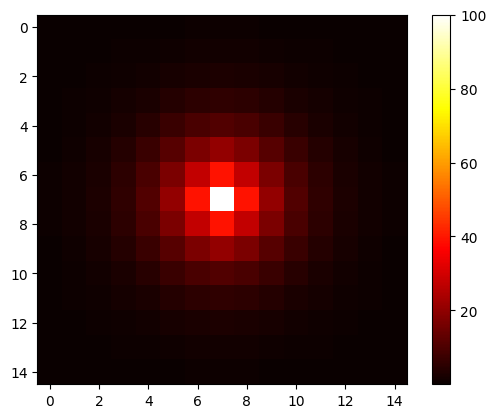

In [179]:
t=50
u = simulate2DDifusion(t,n,α)
plt.imshow(u.reshape(n,n),cmap='hot')
plt.colorbar()


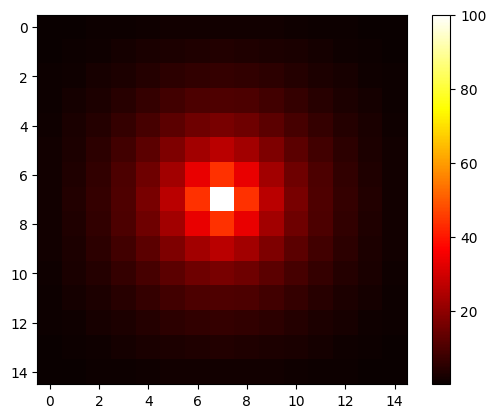

In [180]:
t=100
u = simulate2DDifusion(t,n,α)
plt.imshow(u.reshape(n,n),cmap='hot')
plt.colorbar()
